In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import omicverse as ov
import os

ov.plot_set()
#print(f'cellphonedb version{cellphonedb.__version__}')


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.6, Tutorials: https://omicverse.readthedocs.io/
All dependencies are satisfied.


In [2]:
adata_cellphonedb = sc.read("./pyobjs/slideseq_cell2loc_RCTD_level1.h5ad")
adata_cellphonedb = adata_cellphonedb[adata_cellphonedb.obs["Level1_max_pred_celltype"].isin(["I_Macrophage",
                                                                                              "M_Smooth Muscle",
                                                                                                "M_Steroidogenic Theca",
                                                                                                "M_Medullary Stroma",
                                                                                                "M_Pericyte",
                                                                                                "M_Cortical Stroma",
                                                                                                "M_Dividing Mesenchyme",
                                                                                                "M_Immature Theca"])]
adata_cellphonedb


View of AnnData object with n_obs × n_vars = 130155 × 16455
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'Sample', '_indices', '_scvi_batch', '_scvi_labels', 'total_abundance', 'EN_Blood', 'EN_Lymph', 'Epithelium', 'GC_Antral', 'GC_Atretic', 'GC_CL_Active', 'GC_CL_Lytic', 'GC_Estrous', 'GC_Mitotic', 'GC_Mural', 'GC_Preantral', 'I_B_Cell', 'I_Dendritic_Cell', 'I_Granulocyte', 'I_Macrophage', 'I_T_Cell', 'M_Cortical Stroma', 'M_Dividing Mesenchyme', 'M_Immature Theca', 'M_Medullary Stroma', 'M_Pericyte', 'M_Smooth Muscle', 'M_Steroidogenic Theca', 'Oocyte', 'Level1_max_pred', 'Level1_max_pred_celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts-AAV', 'mean_counts-AAV', 'log1p_mean_counts-AAV', 'pct_dropout_by_counts-AAV', 'total_counts-AAV', 'log1p_total_c

In [39]:
# 创建新的注释列并完成初始映射

adata_cellphonedb.obs["annotation"] = adata_cellphonedb.obs["Level1_max_pred_celltype"]
celltypes = {'M_Steroidogenic Theca': 'Steroidogenic_stromal',
             'M_Smooth Muscle': "Smooth_Muscle",
             'M_Medullary Stroma': "Fibroblast-like_cells",
             'M_Pericyte': 'Pericyte',
             'M_Cortical Stroma': "Fibroblast-like_cells",
             'M_Dividing Mesenchyme': "Dividing_Mesenchyme",
             "M_Immature Theca":"Dividing_Mesenchyme",
             'I_Macrophage':'Macrophage'}

adata_cellphonedb.obs["annotation"] = adata_cellphonedb.obs["annotation"].map(celltypes).astype(str)
# 打印新的注释列的唯一值以确认映射是否正确
print(adata_cellphonedb.obs["annotation"].unique())



['Steroidogenic_stromal' 'Macrophage' 'Smooth_Muscle'
 'Fibroblast-like_cells' 'Pericyte' 'Dividing_Mesenchyme']


In [40]:
import pandas as pd

# 打印新的注释列的唯一值以确认映射是否正确
print(adata_cellphonedb.obs["annotation"].unique())

# 提取 Gpnmb 基因的表达数据
# 确信 Gpnmb 在变量名称中
if "Gpnmb" in adata_cellphonedb.var_names:
    gpnmb_expression = adata_cellphonedb[:, "Gpnmb"].X.toarray().flatten()  # 将表达矩阵转换为一维数组
    adata_cellphonedb.obs["Gpnmb_expression"] = gpnmb_expression

    # 打印前几条表达数据以进行确认
    print(adata_cellphonedb.obs["Gpnmb_expression"].head())

    # 筛选 Macrophage 细胞
    is_macrophage = adata_cellphonedb.obs["annotation"] == "Macrophage"

    # # 将新的类别添加到 annotation 列
    # new_categories = adata_cellphonedb.obs["annotation"].cat.categories.tolist() + ["Macrophage_gpnmb_positive", "Macrophage_gpnmb_negative"]
    # adata_cellphonedb.obs["annotation"].cat.set_categories(new_categories)

    # 基于 Gpnmb 基因的表达状态进行分组并更新 annotation 列
    adata_cellphonedb.obs.loc[is_macrophage & (adata_cellphonedb.obs["Gpnmb_expression"] > 1), "annotation"] = "Macrophage_gpnmb_positive"
    adata_cellphonedb.obs.loc[is_macrophage & (adata_cellphonedb.obs["Gpnmb_expression"] <= 1), "annotation"] = "Macrophage_gpnmb_negative"
    
    # 确保 annotation 列的类型仍为 category
    adata_cellphonedb.obs["annotation"] = adata_cellphonedb.obs["annotation"].astype("category")
    
    # 打印分组后的结果
    print(adata_cellphonedb.obs["annotation"].value_counts())
else:
    print("Error: 'Gpnmb' gene not found in the data.")


['Steroidogenic_stromal' 'Macrophage' 'Smooth_Muscle'
 'Fibroblast-like_cells' 'Pericyte' 'Dividing_Mesenchyme']
s_008um_00630_00352-1-CTR    0.0
s_008um_00598_00455-1-CTR    0.0
s_008um_00265_00607-1-CTR    0.0
s_008um_00348_00371-1-CTR    0.0
s_008um_00562_00549-1-CTR    0.0
Name: Gpnmb_expression, dtype: float32
annotation
Steroidogenic_stromal        55723
Smooth_Muscle                22794
Fibroblast-like_cells        15894
Macrophage_gpnmb_negative    15584
Pericyte                      8723
Dividing_Mesenchyme           7332
Macrophage_gpnmb_positive     2007
Name: count, dtype: int64


In [41]:
adata_cellphonedb.obs["annotation"] = adata_cellphonedb.obs["annotation"].astype("category")
# 打印新的注释列的唯一值以确认映射是否正确
print(adata_cellphonedb.obs["annotation"].value_counts())

annotation
Steroidogenic_stromal        55723
Smooth_Muscle                22794
Fibroblast-like_cells        15894
Macrophage_gpnmb_negative    15584
Pericyte                      8723
Dividing_Mesenchyme           7332
Macrophage_gpnmb_positive     2007
Name: count, dtype: int64


In [20]:
# the cell cyle gene extracted from seurat (cc.genes)
s_genes = list(pd.read_csv("./csv/s_genes.csv")["V2"])
g2m_genes = list(pd.read_csv("./csv/g2m_genes.csv")["V2"])
print(s_genes)
print(g2m_genes)
sc.pp.normalize_total(adata_cellphonedb, inplace=True)
# Note that our data cannot be scaled.
# sc.pp.log1p(adata_cellphonedb)
sc.tl.score_genes_cell_cycle(adata_cellphonedb, s_genes=s_genes, g2m_genes=g2m_genes)


['Mcm5', 'Pcna', 'Tyms', 'Fen1', 'Mcm7', 'Mcm4', 'Rrm1', 'Ung', 'Gins2', 'Mcm6', 'Cdca7', 'Dtl', 'Prim1', 'Uhrf1', 'Cenpu', 'Hells', 'Rfc2', 'Polr1b', 'Nasp', 'Rad51ap1', 'Gmnn', 'Wdr76', 'Slbp', 'Ccne2', 'Ubr7', 'Pold3', 'Msh2', 'Atad2', 'Rad51', 'Rrm2', 'Cdc45', 'Cdc6', 'Exo1', 'Tipin', 'Dscc1', 'Blm', 'Casp8ap2', 'Usp1', 'Clspn', 'Pola1', 'Chaf1b', 'Mrpl36', 'E2f8']
['Hmgb2', 'Cdk1', 'Nusap1', 'Ube2c', 'Birc5', 'Tpx2', 'Top2a', 'Ndc80', 'Cks2', 'Nuf2', 'Cks1b', 'Mki67', 'Tmpo', 'Cenpf', 'Tacc3', 'Pimreg', 'Smc4', 'Ccnb2', 'Ckap2l', 'Ckap2', 'Aurkb', 'Bub1', 'Kif11', 'Anp32e', 'Tubb4b', 'Gtse1', 'Kif20b', 'Hjurp', 'Cdca3', 'Jpt1', 'Cdc20', 'Ttk', 'Cdc25c', 'Kif2c', 'Rangap1', 'Ncapd2', 'Dlgap5', 'Cdca2', 'Cdca8', 'Ect2', 'Kif23', 'Hmmr', 'Aurka', 'Psrc1', 'Anln', 'Lbr', 'Ckap5', 'Cenpe', 'Ctcf', 'Nek2', 'G2e3', 'Gas2l3', 'Cbx5', 'Cenpa']
normalizing counts per cell
    finished (0:00:00)
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score o

In [23]:
# sc.pp.highly_variable_genes(adata_cellphonedb, n_top_genes=5000)
# sc.pl.highly_variable_genes(adata_cellphonedb)

In [43]:
adata_cellphonedb.obs["annotation"].value_counts()

annotation
Steroidogenic_stromal        55723
Smooth_Muscle                22794
Fibroblast-like_cells        15894
Macrophage_gpnmb_negative    15584
Pericyte                      8723
Dividing_Mesenchyme           7332
Macrophage_gpnmb_positive     2007
Name: count, dtype: int64

[<AxesSubplot: title={'center': 'ctr'}, xlabel='spatial1', ylabel='spatial2'>]

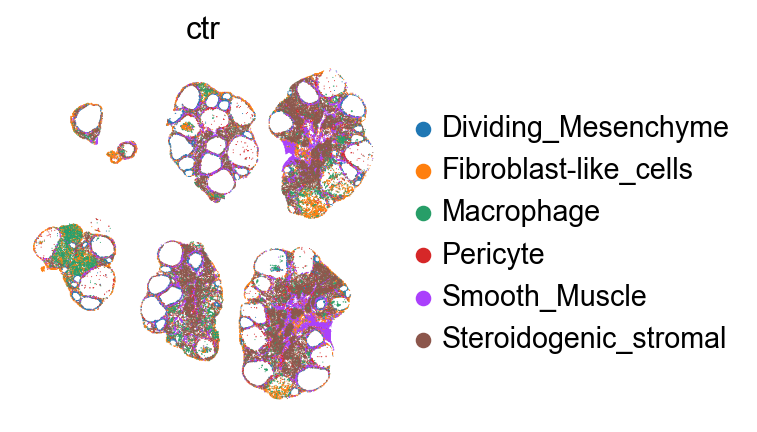

In [50]:
# 创建一个仅用于保存图例的图形
fig, ax = plt.subplots(figsize=(3, 6))  # 这里定义图例保存图形尺寸


subset = adata_cellphonedb[adata_cellphonedb.obs["Sample"] == 'CTR']

sc.pl.spatial(subset, color=['annotation'], 
                wspace=0.0, hspace=0.0, spot_size=30, 
                frameon=False, title="ctr", show=False, ax=ax)


In [25]:


sc.pp.filter_cells(adata_cellphonedb, min_genes=200)
sc.pp.filter_genes(adata_cellphonedb, min_cells=3)
adata_cellphonedb.raw = adata_cellphonedb
# adata_cellphonedb = adata_cellphonedb[:, adata_cellphonedb.var.highly_variable]
print(adata_cellphonedb.shape)


filtered out 2098 cells that have less than 200 genes expressed
filtered out 34 genes that are detected in less than 3 cells
(128057, 16421)


In [44]:
adata_cellphonedb.write_h5ad("Integrate/cellphonedb.h5ad")

In [64]:
import scanpy as sc
import pandas as pd
import anndata as ad
from gseapy import Biomart

# # Step 1: 读取 AnnData 对象
# adata_cellphonedb = sc.read_h5ad('path/to/your/mouse_data.h5ad')

# Step 2: 使用 Biomart 获取转换表
bm = Biomart()
# 查询小鼠到人类基因的转换表
m2h = bm.query(dataset='mmusculus_gene_ensembl',
               attributes=['ensembl_gene_id', 'external_gene_name',
                           'hsapiens_homolog_ensembl_gene', 'hsapiens_homolog_associated_gene_name'])

# 创建映射字典
mouse_to_human_genes = dict(zip(m2h['external_gene_name'], m2h['hsapiens_homolog_associated_gene_name']))

# 打印部分转换结果以进行验证
print("Gene mapping example (mouse to human):", list(mouse_to_human_genes.items())[:10])
# 替换 AnnData 对象中的基因名，并去掉转换过程中没有找到对应人类基因的基因
converted_var_names = []
indices_to_keep = []

for i, gene in enumerate(adata_cellphonedb.var_names):
    human_gene = mouse_to_human_genes.get(gene, None)
    if human_gene is not None and pd.notna(human_gene):
        converted_var_names.append(human_gene)
        indices_to_keep.append(i)

print(f"Number of genes removed during conversion: {len(adata_cellphonedb.var_names) - len(indices_to_keep)}")

# 保留成功转换的基因对应的列
print(adata_cellphonedb.shape)
adata_cellphonedb = adata_cellphonedb[:, indices_to_keep]
print(adata_cellphonedb.shape)
adata_cellphonedb.var_names = converted_var_names



Gene mapping example (mouse to human): [('mt-Tf', nan), ('mt-Rnr1', nan), ('mt-Tv', nan), ('mt-Rnr2', nan), ('mt-Tl1', nan), ('mt-Nd1', 'MT-ND1'), ('mt-Ti', nan), ('mt-Tq', nan), ('mt-Tm', nan), ('mt-Nd2', 'MT-ND2')]
Number of genes removed during conversion: 1525
(130155, 16455)
(130155, 14930)


In [65]:
# Step 4: 构建新的 AnnData 对象
adata1 = ad.AnnData(
    X=adata_cellphonedb.X,
    obs=adata_cellphonedb.obs.copy(),
    var=adata_cellphonedb.var.copy()
)

# 保存 AnnData 对象，准备用于 CellphoneDB 分析
output_file_path = 'Integrate/cpdb/norm_log.h5ad'  # 修改保存路径为你希望保存的位置
adata1.write_h5ad(output_file_path, compression='gzip')

print(f"AnnData object saved to {output_file_path}")

AnnData object saved to Integrate/cpdb/norm_log.h5ad


In [66]:
adata1.var_names

Index(['A1BG', 'A1CF', 'A2M', 'A3GALT2', 'A4GALT', 'A4GNT', 'C15orf48',
       'C1orf116', 'C19orf38', 'C5',
       ...
       'ZSWIM8', 'ZW10', 'ZWILCH', 'ZWINT', 'ZXDC', 'ZYG11B', 'ZYX', 'ZZEF1',
       'ZZZ3', 'ASIP'],
      dtype='object', length=14930)

In [67]:
#meta导出
df_meta = pd.DataFrame(data={'Cell':list(adata_cellphonedb[adata1.obs.index].obs.index),
                             'cell_type':[ i for i in adata_cellphonedb[adata1.obs.index].obs['annotation']]
                            })
df_meta.set_index('Cell', inplace=True)
df_meta.to_csv('Integrate/cpdb/meta.tsv', sep = '\t')

In [11]:
import os
os.getcwd() 

'd:\\program\\HD\\python'

In [68]:
cpdb_file_path = os.getcwd()+'/Integrate/cpdb/cellphonedb.zip'
meta_file_path = os.getcwd()+'/Integrate/cpdb/meta.tsv'
counts_file_path = os.getcwd()+'/Integrate/cpdb/norm_log.h5ad'
microenvs_file_path = None
active_tf_path = None
out_path =os.getcwd()+'/Integrate/cpdb/test_cellphone'

In [69]:
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method

cpdb_results = cpdb_statistical_analysis_method.call(
    cpdb_file_path = cpdb_file_path,                 # mandatory: CellphoneDB database zip file.
    meta_file_path = meta_file_path,                 # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = counts_file_path,             # mandatory: normalized count matrix - a path to the counts file, or an in-memory AnnData object
    counts_data = 'hgnc_symbol',                     # defines the gene annotation in counts matrix.
    active_tfs_file_path = active_tf_path,           # optional: defines cell types and their active TFs.
    microenvs_file_path = microenvs_file_path,       # optional (default: None): defines cells per microenvironment.
    score_interactions = True,                       # optional: whether to score interactions or not. 
    iterations = 1000,                               # denotes the number of shufflings performed in the analysis.
    threshold = 0.1,                                 # defines the min % of cells expressing a gene for this to be employed in the analysis.
    threads = 10,                                     # number of threads to use in the analysis.
    debug_seed = 42,                                 # debug randome seed. To disable >=0.
    result_precision = 3,                            # Sets the rounding for the mean values in significan_means.
    pvalue = 0.05,                                   # P-value threshold to employ for significance.
    subsampling = False,                             # To enable subsampling the data (geometri sketching).
    subsampling_log = False,                         # (mandatory) enable subsampling log1p for non log-transformed data inputs.
    subsampling_num_pc = 100,                        # Number of componets to subsample via geometric skectching (dafault: 100).
    subsampling_num_cells = 1000,                    # Number of cells to subsample (integer) (default: 1/3 of the dataset).
    separator = '|',                                 # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    debug = False,                                   # Saves all intermediate tables employed during the analysis in pkl format.
    output_path = out_path,                          # Path to save results.
    output_suffix = None                             # Replaces the timestamp in the output files by a user defined string in the  (default: None).
    )

Reading user files...
The following user files were loaded successfully:
d:\program\HD\python/Integrate/cpdb/norm_log.h5ad
d:\program\HD\python/Integrate/cpdb/meta.tsv
[ ][CORE][22/09/24-20:09:16][INFO] [Cluster Statistical Analysis] Threshold:0.1 Iterations:1000 Debug-seed:42 Threads:10 Precision:3
[ ][CORE][22/09/24-20:09:16][WARNING] Debug random seed enabled. Set to 42
[ ][CORE][22/09/24-20:09:19][INFO] Running Real Analysis
[ ][CORE][22/09/24-20:09:19][INFO] Running Statistical Analysis


100%|██████████| 1000/1000 [13:32<00:00,  1.23it/s]

[ ][CORE][22/09/24-20:22:52][INFO] Building Pvalues result
[ ][CORE][22/09/24-20:22:53][INFO] Building results


[ ][CORE][22/09/24-20:22:53][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 6/6 [00:01<00:00,  3.40it/s]

[ ][CORE][22/09/24-20:22:55][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 6/6 [00:00<00:00, 12.35it/s]


[ ][CORE][22/09/24-20:22:56][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 36/36 [00:11<00:00,  3.07it/s]


Saved deconvoluted to d:\program\HD\python/Integrate/cpdb/test_cellphone\statistical_analysis_deconvoluted_09_22_2024_202308.txt
Saved deconvoluted_percents to d:\program\HD\python/Integrate/cpdb/test_cellphone\statistical_analysis_deconvoluted_percents_09_22_2024_202308.txt
Saved means to d:\program\HD\python/Integrate/cpdb/test_cellphone\statistical_analysis_means_09_22_2024_202308.txt
Saved pvalues to d:\program\HD\python/Integrate/cpdb/test_cellphone\statistical_analysis_pvalues_09_22_2024_202308.txt
Saved significant_means to d:\program\HD\python/Integrate/cpdb/test_cellphone\statistical_analysis_significant_means_09_22_2024_202308.txt
Saved interaction_scores to d:\program\HD\python/Integrate/cpdb/test_cellphone\statistical_analysis_interaction_scores_09_22_2024_202308.txt


In [70]:
ov.utils.save(cpdb_results,'Integrate/cpdb/gex_cpdb_test.pkl')

In [117]:
adata1 = sc.read_h5ad("Integrate/cpdb/norm_log.h5ad")
adata1

AnnData object with n_obs × n_vars = 130155 × 14930
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'Sample', '_indices', '_scvi_batch', '_scvi_labels', 'total_abundance', 'EN_Blood', 'EN_Lymph', 'Epithelium', 'GC_Antral', 'GC_Atretic', 'GC_CL_Active', 'GC_CL_Lytic', 'GC_Estrous', 'GC_Mitotic', 'GC_Mural', 'GC_Preantral', 'I_B_Cell', 'I_Dendritic_Cell', 'I_Granulocyte', 'I_Macrophage', 'I_T_Cell', 'M_Cortical Stroma', 'M_Dividing Mesenchyme', 'M_Immature Theca', 'M_Medullary Stroma', 'M_Pericyte', 'M_Smooth Muscle', 'M_Steroidogenic Theca', 'Oocyte', 'Level1_max_pred', 'Level1_max_pred_celltype', 'annotation', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts-AAV', 'mean_counts-AAV', 'log1p_mean_counts-AAV', 'pct_dropout_by_counts-A

In [15]:
cpdb_results=ov.utils.load('Integrate/cpdb/gex_cpdb_test.pkl')

In [71]:
interaction=ov.single.cpdb_network_cal(adata = adata1,
        pvals = cpdb_results['pvalues'],
        celltype_key = "cell_labels",)   

ktplotspy have been install version: 0.2.4


In [72]:
interaction

{'count_network':                        Dividing_Mesenchyme  Fibroblast-like_cells  Macrophage  \
 Dividing_Mesenchyme                   54.0                   48.0        28.0   
 Fibroblast-like_cells                 50.0                   41.0        23.0   
 Macrophage                            35.0                   34.0        14.0   
 Pericyte                              54.0                   49.0        28.0   
 Smooth_Muscle                         43.0                   38.0        22.0   
 Steroidogenic_stromal                 35.0                   25.0        10.0   
 
                        Pericyte  Smooth_Muscle  Steroidogenic_stromal  
 Dividing_Mesenchyme        46.0           37.0                   25.0  
 Fibroblast-like_cells      38.0           37.0                   21.0  
 Macrophage                 31.0           34.0                   15.0  
 Pericyte                   48.0           41.0                   20.0  
 Smooth_Muscle              34.0          

In [73]:
interaction['interaction_edges'].head()

SOURCE                 TARGET  COUNT
0  Dividing_Mesenchyme    Dividing_Mesenchyme     54
1  Dividing_Mesenchyme  Fibroblast-like_cells     50
2  Dividing_Mesenchyme             Macrophage     35
3  Dividing_Mesenchyme               Pericyte     54
4  Dividing_Mesenchyme          Smooth_Muscle     43

In [74]:
ov.plot_set()

Dependency error: (pydeseq2 0.4.11 (f:\anaconda\envs\omicverse\lib\site-packages), Requirement.parse('pydeseq2<=0.4.0,>=0.3'))


In [75]:
adata1.obs["cell_labels"] = adata1.obs["annotation"]

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 1168.0970537219262
Plotting legends..
Estimated legend width: 14.465277777777779 mm


<Axes: ylabel='COUNT'>

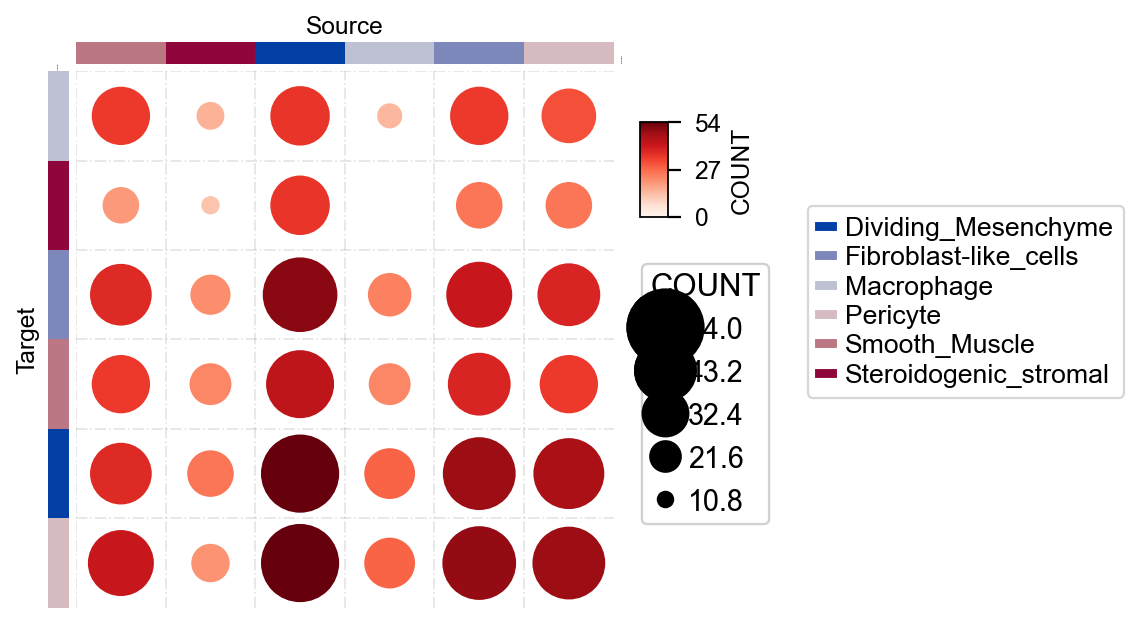

In [76]:
fig, ax = plt.subplots(figsize=(4,4)) 
ov.pl.cpdb_heatmap(adata1,interaction['interaction_edges'],
                   celltype_key='annotation',
                   fontsize=11,
          ax=ax,legend_kws={'fontsize':12,'bbox_to_anchor':(5, -0.9),'loc':'center left',})

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 390.67723538305466
Plotting legends..
Estimated legend width: 14.465277777777779 mm


<Axes: ylabel='COUNT'>

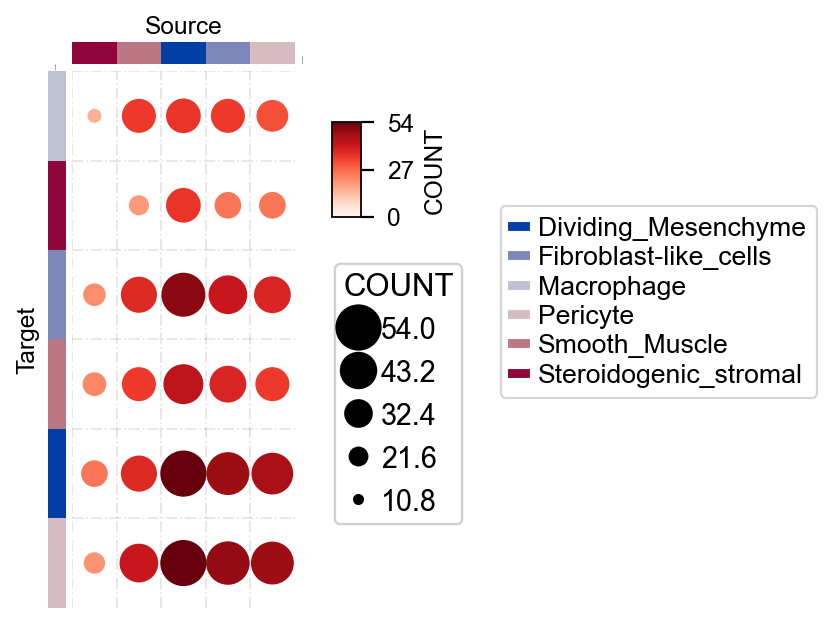

In [77]:
fig, ax = plt.subplots(figsize=(2,4)) 
ov.pl.cpdb_heatmap(adata1,interaction['interaction_edges'],celltype_key='annotation',
                   source_cells=[
                                          "Steroidogenic_stromal",
                                          "Smooth_Muscle",
                                          "Pericyte",
                                          "Fibroblast-like_cells",
                                          "Dividing_Mesenchyme"
                                          ],
          ax=ax,legend_kws={'fontsize':12,'bbox_to_anchor':(5, -0.9),'loc':'center left',})

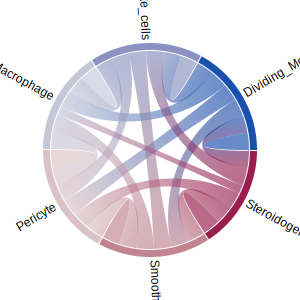

In [79]:
fig=ov.pl.cpdb_chord(adata1,interaction['interaction_edges'],celltype_key='annotation',
          count_min=10,fontsize=12,padding=50,radius=100,save=None,)
fig.show()

<AxesSubplot: >

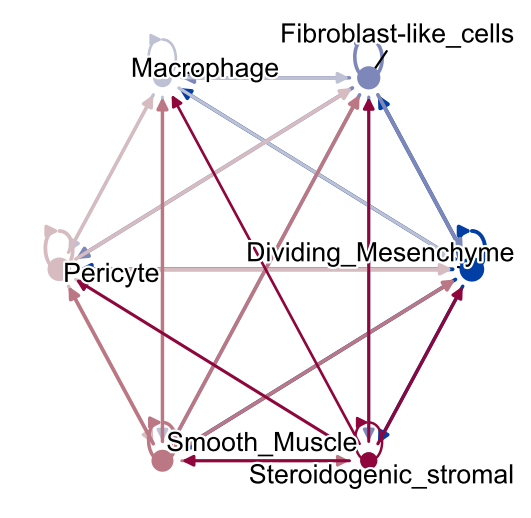

In [81]:
fig, ax = plt.subplots(figsize=(4,4)) 
ov.pl.cpdb_network(adata1,interaction['interaction_edges'],celltype_key='annotation',
             counts_min=10,
            nodesize_scale=5,
                  ax=ax)

<AxesSubplot: >

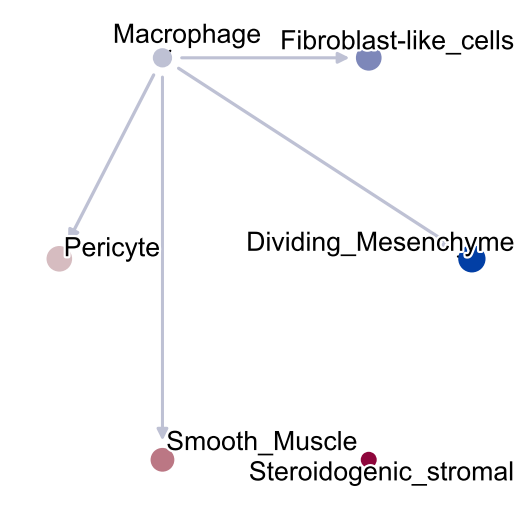

In [88]:
fig, ax = plt.subplots(figsize=(4,4)) 
ov.pl.cpdb_network(adata1,interaction['interaction_edges'],celltype_key='annotation',
            counts_min=20,
            nodesize_scale=4,
            source_cells=['Macrophage'],
            ax=ax)

In [83]:


sub_means=ov.single.cpdb_exact_target(cpdb_results['means'],[
                                          "Steroidogenic_stromal",
                                          "Smooth_Muscle",
                                          "Pericyte",
                                          "Fibroblast-like_cells",
                                          "Dividing_Mesenchyme"
                                          ])
sub_means=ov.single.cpdb_exact_source(sub_means,["Macrophage"])
sub_means.sample(10)


id_cp_interaction                                   interacting_pair  \
513    CPI-CS0BE6576AD                         Testosterone_byHSD17B12_AR   
250    CPI-SC00D92ECAF                        FCER2_integrin_aMb2_complex   
2075   CPI-SC061351B3F                                     WNT2_FZD8_LRP6   
1383   CPI-CC0063E25BD  Glutamate_byGLS_and_SLC1A3_Glutamate_Kainate_2...   
1630   CPI-CS0975DD44D                   Glutamate_byGLS2_and_SLC1A2_GRM7   
1122   CPI-CC0CCDF6512      GABA_byGAD2_and_SLC6A1_GABA-A_a3b3g2S_complex   
308    CPI-SS0CEFF4625                                          GJC1_GJC1   
2575   CPI-SC0B4243FE6                                    WNT7B_FZD4_LRP6   
1918   CPI-SS0BDC912F3                                        CNTN1_NRCAM   
2120   CPI-CC01AF691C1      atRetinoicAcid_byALDH1A1_RAreceptor_RARG_RXRG   

                                partner_a  \
513       complex:Testosterone_byHSD17B12   
250                         simple:P06734   
2075                        simple:P09544   
1383   complex:Glutamate_byGLS_and_SLC1A3   
1630  complex:Glutamate_byGLS2_and_SLC1A2   
1122       complex:GABA_byGAD2_and_SLC6A1   
308                         simple:P36383   
2575                        simple:P56706   
1918                        simple:Q12860   
2120     complex:atRetinoicAcid_byALDH1A1   

                                  partner_b gene_a gene_b  secreted  \
513                           simple:P10275    NaN     AR      True   
250           complex:integrin_aMb2_complex  FCER2    NaN      True   
2075                      complex:FZD8_LRP6   WNT2    NaN      True   
1383  complex:Glutamate_Kainate_2_4_complex    NaN    NaN      True   
1630                          simple:Q14831    NaN   GRM7      True   
1122         complex:GABA-A_a3b3g2S_complex    NaN    NaN      True   
308                           simple:P36383   GJC1   GJC1     False   
2575                      complex:FZD4_LRP6  WNT7B    NaN      True   
1918                          simple:Q92823  CNTN1  NRCAM      True   
2120           complex:RAreceptor_RARG_RXRG    NaN    NaN      True   

      receptor_a  receptor_b annotation_strategy  \
513        False        True             curated   
250         True       False             curated   
2075       False       False             curated   
1383       False        True             curated   
1630       False        True             curated   
1122       False        True             curated   
308        False       False             curated   
2575       False       False             curated   
1918       False       False             curated   
2120       False        True             curated   

      Macrophage|Steroidogenic_stromal  Macrophage|Smooth_Muscle  \
513                              0.116                     0.097   
250                              0.004                     0.007   
2075                             0.011                     0.021   
1383                             0.005                     0.005   
1630                             0.008                     0.004   
1122                             0.000                     0.000   
308                              0.013                     0.020   
2575                             0.021                     0.021   
1918                             0.077                     0.029   
2120                             1.143                     1.143   

      Macrophage|Pericyte  Macrophage|Fibroblast-like_cells  \
513                 0.096                             0.095   
250                 0.005                             0.008   
2075                0.016                             0.021   
1383                0.005                             0.005   
1630                0.014                             0.005   
1122                0.000                             0.000   
308                 0.042                             0.018   
2575                0.029                            

ValueError: zero-size array to reduction operation fmin which has no identity

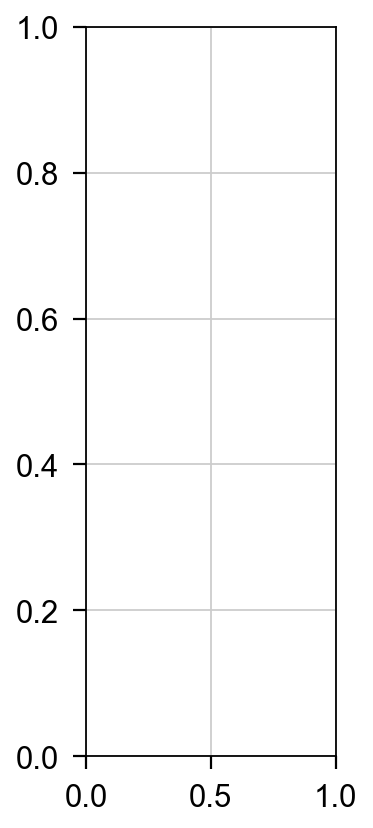

In [87]:
import omicverse as ov
import numpy as np
import pandas as pd

# 加载 CellphoneDB 结果
cpdb_results = ov.utils.load('Integrate/cpdb/gex_cpdb_test.pkl')

# 检查并去除全 NaN 的行和列
# 去除 means 中含全 NaN 的行
means_cleaned = cpdb_results['means'].dropna(axis=0, how='all')
# 去除 means 中含全 NaN 的列
means_cleaned = means_cleaned.dropna(axis=1, how='all')

# 去除 pvalues 中含全 NaN 的行
pvalues_cleaned = cpdb_results['pvalues'].dropna(axis=0, how='all')
# 去除 pvalues 中含全 NaN 的列
pvalues_cleaned = pvalues_cleaned.dropna(axis=1, how='all')

# 确保 means 和 pvalues 具有相同的维度
means_cleaned = means_cleaned[means_cleaned.index.isin(pvalues_cleaned.index)]
pvalues_cleaned = pvalues_cleaned[pvalues_cleaned.index.isin(means_cleaned.index)]

# 使用清理后的数据进行绘图
ov.pl.cpdb_interacting_heatmap(adata=adata1,
                              celltype_key='annotation',
                              means=means_cleaned,
                              pvalues=pvalues_cleaned,
                              source_cells=["Macrophage"],
                              target_cells=["Fibroblast-like_cells"],
                              plot_secret=True,
                              min_means=3,
                              nodecolor_dict=None,
                              ax=None,
                              figsize=(2, 6),
                              fontsize=10)


In [2]:
import scanpy as sc
import numpy as np
import scipy

# # 读取 AnnData 对象
adata_cellphonedb = sc.read_h5ad('Integrate/cellphonedb.h5ad')
adata_cellphonedb.raw = adata_cellphonedb.copy()


In [3]:
from liana.method import cellphonedb
# run cellphonedb
cellphonedb(adata_cellphonedb,
            groupby='annotation',
            # NOTE by default the resource uses HUMAN gene symbols
            resource_name='mouseconsensus',
            expr_prop=0.1,
            verbose=True, key_added='cpdb_res')

Using resource `mouseconsensus`.
Using `.raw`!
0.07 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 128057 samples and 1477 features


100%|██████████| 1000/1000 [01:26<00:00, 11.54it/s]


In [4]:
# Let’s examine the output from the CellPhoneDB method:
# by default, liana's output is saved in place:
adata_cellphonedb.uns['cpdb_res'].head()

ligand ligand_complex  ligand_means  ligand_props receptor  \
13225   Apoe           Apoe     15.159801      0.981066   Scarb1   
13323   Apoe           Apoe     15.159801      0.981066    Abca1   
5384    Apoe           Apoe     15.159801      0.981066   Scarb1   
7395    Apoe           Apoe     15.159801      0.981066   Scarb1   
7394    Apoe           Apoe     15.159801      0.981066     Lrp1   

      receptor_complex  receptor_means  receptor_props  \
13225           Scarb1        3.299160        0.817723   
13323            Abca1        2.219411        0.868941   
5384            Scarb1        1.567792        0.584831   
7395            Scarb1        1.428569        0.570503   
7394              Lrp1        1.252605        0.633284   

                          source                     target  lr_means  \
13225  Macrophage_gpnmb_positive      Steroidogenic_stromal  9.229481   
13323  Macrophage_gpnmb_positive      Steroidogenic_stromal  8.689606   
5384   Macrophage_gpnmb_positive  Macrophage_gpnmb_negative  8.363796   
7395   Macrophage_gpnmb_positive  Macrophage_gpnmb_positive  8.294185   
7394   Macrophage_gpnmb_positive  Macrophage_gpnmb_positive  8.206203   

       cellphone_pvals  
13225              0.0  
13323              0.0  
5384               0.0  
7395               0.0  
7394               0.0

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


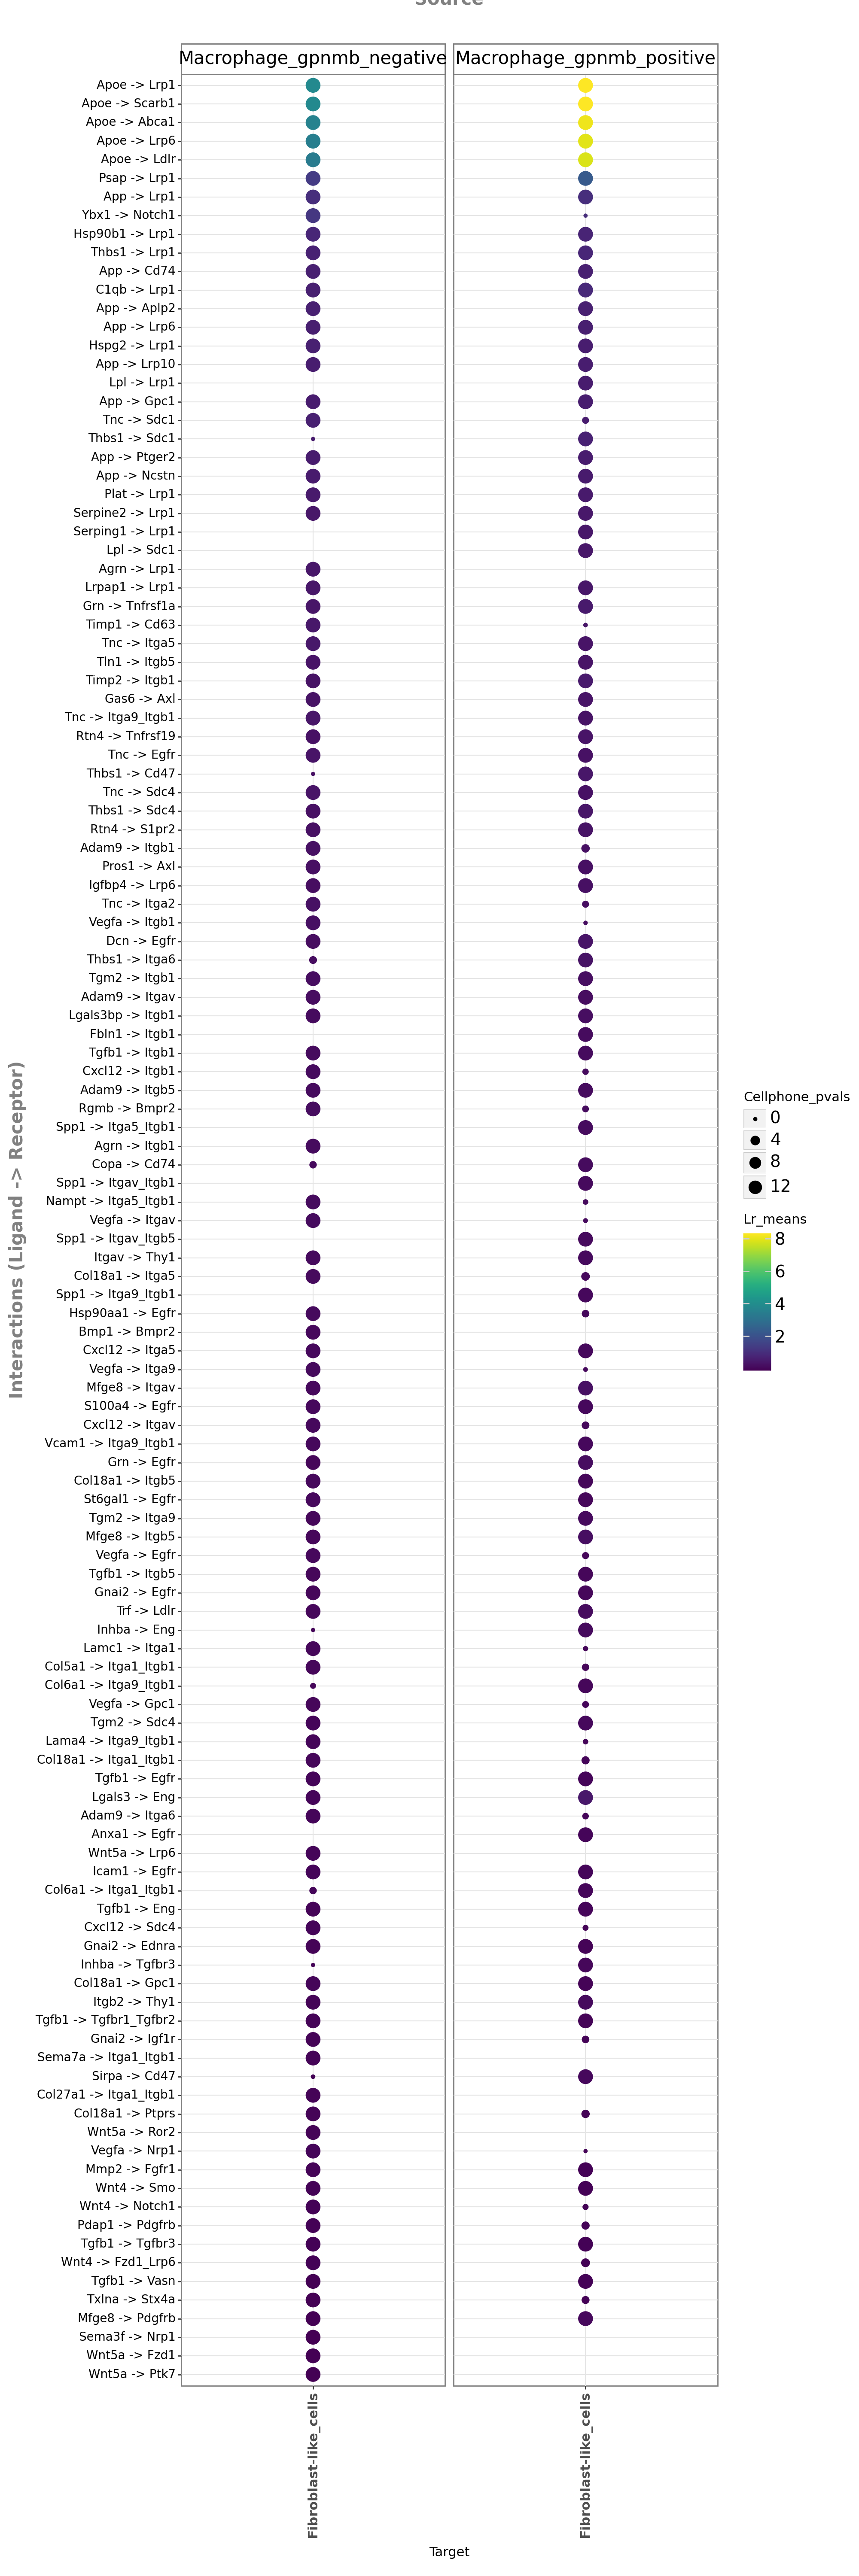

<Figure Size: (1000 x 3000)>

In [5]:
import liana as li
li.pl.dotplot(
    adata=adata_cellphonedb,
    colour="lr_means",
    size="cellphone_pvals",
    inverse_size=True,  # we inverse sign since we want small p-values to have large sizes
    # We choose only the cell types which we wish to plot
    source_labels=["Macrophage_gpnmb_positive","Macrophage_gpnmb_negative"],
    target_labels=[
                                        #   "Steroidogenic_stromal",
                                        #   "Smooth_Muscle",
                                        #   "Pericyte",
                                          "Fibroblast-like_cells"
                                        #   "Dividing_Mesenchyme"
                                          ],

    # since cpdbv2 suggests using a filter to FPs
    # we can filter the interactions according to p-values <= 0.01
    # filterby="cellphone_pvals",
    # filter_lambda=lambda x: x <= 0.01,
    # as this type of methods tends to result in large numbers
    # of predictions, we can also further order according to
    # expression magnitude
    filter_fun=lambda x: x['cellphone_pvals'] <= 0.0005,
    orderby="lr_means",
    orderby_ascending=True,  # we want to prioritize those with highest expression
    top_n=50000,  # and we want to keep only the top 20 interactions
    figure_size=(10, 30),
    size_range=(1, 6),
    uns_key='cpdb_res'
)

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


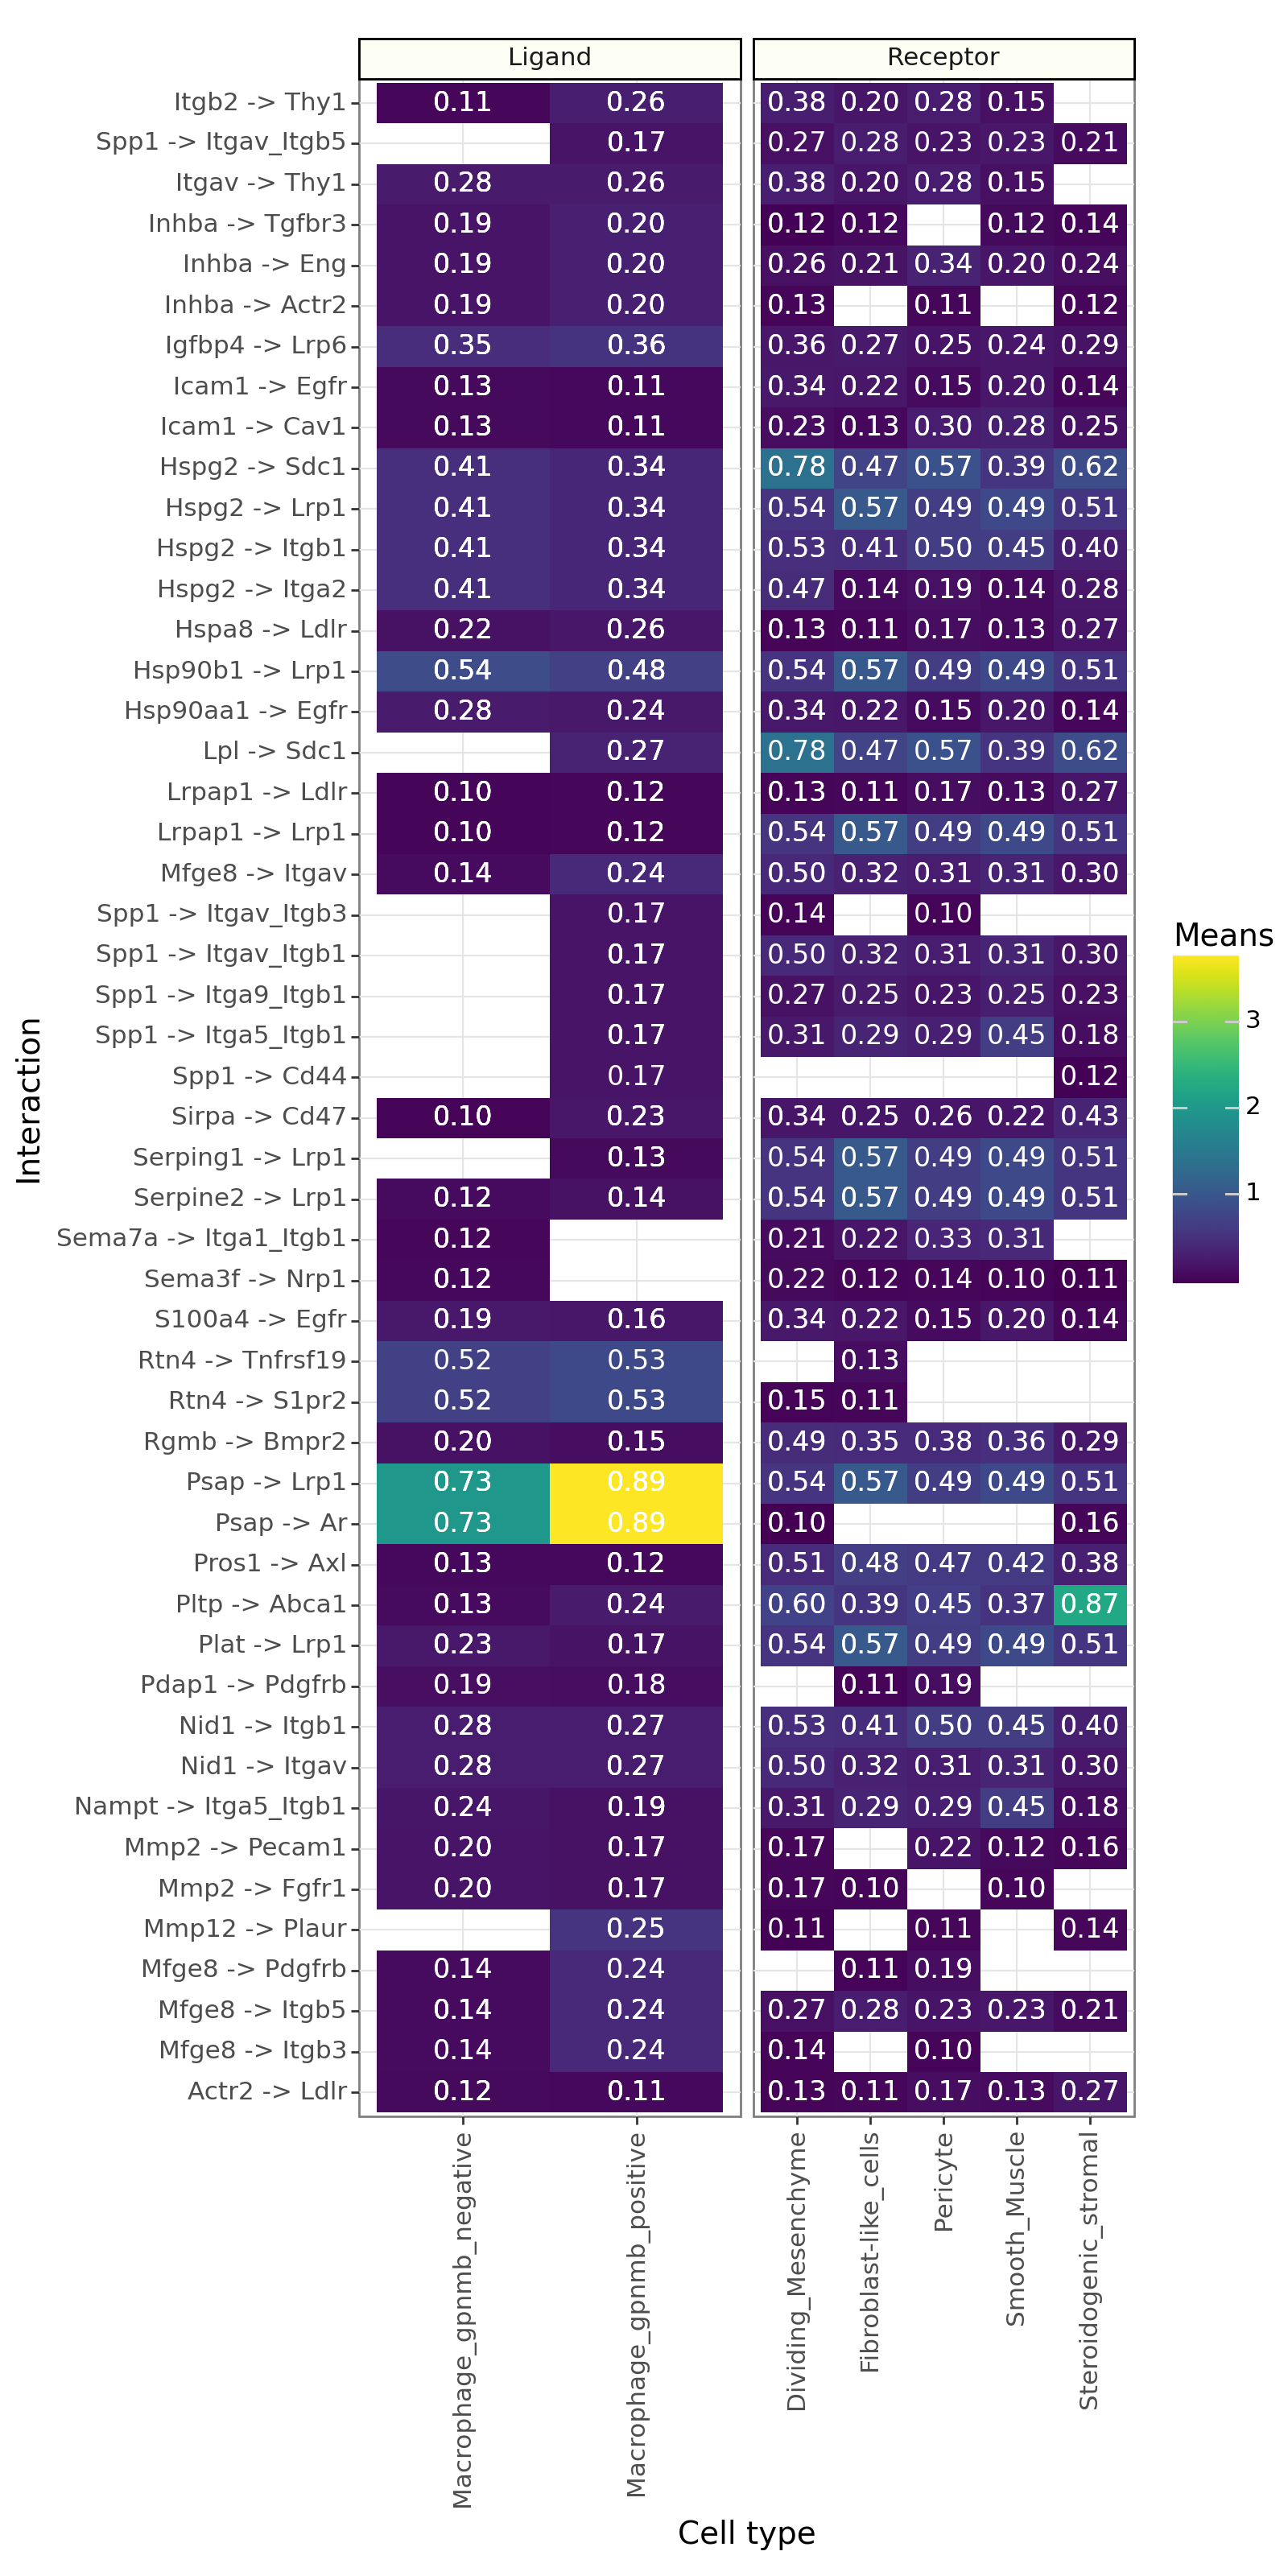

<Figure Size: (800 x 1600)>

In [6]:
my_plot = li.pl.tileplot(adata = adata_cellphonedb,
                         # NOTE: fill & label need to exist for both
                         # ligand_ and receptor_ columns
                         fill='means',
                         label='props',
                         label_fun=lambda x: f'{x:.2f}',
                         top_n=50,
                         orderby='cellphone_pvals',
                         orderby_ascending=True,
                         source_labels=["Macrophage_gpnmb_positive","Macrophage_gpnmb_negative"],
                         target_labels=[
                                          "Steroidogenic_stromal",
                                          "Smooth_Muscle",
                                          "Pericyte",
                                          "Fibroblast-like_cells",
                                          "Dividing_Mesenchyme"
                                          ],
                         uns_key='cpdb_res', # NOTE: default is 'liana_res'
                         source_title='Ligand',
                         target_title='Receptor',
                         figure_size=(8, 16)
                         )
my_plot



In [7]:
# Run rank_aggregate
li.mt.rank_aggregate(adata_cellphonedb,
                     groupby='annotation',
                     resource_name='mouseconsensus',
                     expr_prop=0.1,
                     verbose=True)



Using resource `mouseconsensus`.
Using `.raw`!
0.07 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 128057 samples and 1477 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [01:26<00:00, 11.62it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


In [8]:
adata_cellphonedb.uns['liana_res'].head()

source                     target ligand_complex  \
6623  Macrophage_gpnmb_positive      Steroidogenic_stromal           Apoe   
6619  Macrophage_gpnmb_positive      Steroidogenic_stromal           Apoe   
5752  Macrophage_gpnmb_positive  Macrophage_gpnmb_negative           Apoe   
5968  Macrophage_gpnmb_positive  Macrophage_gpnmb_positive           Apoe   
5966  Macrophage_gpnmb_positive  Macrophage_gpnmb_positive           Apoe   

     receptor_complex  lr_means  cellphone_pvals  expr_prod  scaled_weight  \
6623           Scarb1  9.229481              0.0  50.014606       1.823582   
6619            Abca1  8.689606              0.0  33.645828       1.815274   
5752           Scarb1  8.363796              0.0  23.767410       1.468404   
5968           Scarb1  8.294185              0.0  21.656815       1.439850   
5966             Lrp1  8.206203              0.0  18.989244       1.814990   

      lr_logfc  spec_weight   lrscore  specificity_rank  magnitude_rank  
6623       NaN     0.174817  0.992013               NaN    6.690388e-08  
6619       NaN     0.167427  0.990279               NaN    2.676002e-07  
5752       NaN     0.083075  0.988455               NaN    6.020657e-07  
5968       NaN     0.075698  0.987913               NaN    1.672213e-06  
5966       NaN     0.114376  0.987102               NaN    2.407848e-06

In [9]:
df = adata_cellphonedb.uns['liana_res']
# 查找基因为 'Gpnmb' 或 'Enpp2' 的行
result = df[df['ligand_complex'].isin(['Gpnmb'])]

# 显示结果
print(result)

Empty DataFrame
Columns: [source, target, ligand_complex, receptor_complex, lr_means, cellphone_pvals, expr_prod, scaled_weight, lr_logfc, spec_weight, lrscore, specificity_rank, magnitude_rank]
Index: []


In [10]:
li.mt.rank_aggregate.describe()

Rank_Aggregate returns `magnitude_rank`, `specificity_rank`. magnitude_rank and specificity_rank respectively represent an aggregate of the `magnitude`- and `specificity`-related scoring functions from the different methods.


In [11]:
# 假设我们感兴趣的基因列表如下
# adata_cellphonedb.write_h5ad("Integrate/liana_adata.h5ad")


In [2]:
adata_cellphonedb = sc.read_h5ad("./Integrate/liana_adata.h5ad")

In [6]:
# 过滤 liana_res 以仅保留感兴趣的基因
import liana as li
liana_res_filtered = adata_cellphonedb.uns['liana_res']
liana_res_filtered = liana_res_filtered[liana_res_filtered["cellphone_pvals"] <= 0.05]
liana_res_filtered

source                     target ligand_complex  \
6623   Macrophage_gpnmb_positive      Steroidogenic_stromal           Apoe   
6619   Macrophage_gpnmb_positive      Steroidogenic_stromal           Apoe   
5752   Macrophage_gpnmb_positive  Macrophage_gpnmb_negative           Apoe   
5968   Macrophage_gpnmb_positive  Macrophage_gpnmb_positive           Apoe   
5966   Macrophage_gpnmb_positive  Macrophage_gpnmb_positive           Apoe   
...                          ...                        ...            ...   
2501       Fibroblast-like_cells      Fibroblast-like_cells          Txlna   
11569      Steroidogenic_stromal      Steroidogenic_stromal          Timp3   
2510       Fibroblast-like_cells      Fibroblast-like_cells           Wnt4   
2512       Fibroblast-like_cells      Fibroblast-like_cells          Wnt5a   
2509       Fibroblast-like_cells      Fibroblast-like_cells           Wnt4   

      receptor_complex  lr_means  cellphone_pvals  expr_prod  scaled_weight  \
6623            Scarb1  9.229481              0.0  50.014606       1.823582   
6619             Abca1  8.689606              0.0  33.645828       1.815274   
5752            Scarb1  8.363796              0.0  23.767410       1.468404   
5968            Scarb1  8.294185              0.0  21.656815       1.439850   
5966              Lrp1  8.206203              0.0  18.989244       1.814990   
...                ...       ...              ...        ...            ...   
2501             Stx4a  0.145118              0.0   0.020788       0.047426   
11569             Cd44  0.282620              0.0   0.037496       0.022034   
2510            Notch1  0.202104              0.0   0.036219       0.137645   
2512              Fzd1  0.160866              0.0   0.024308       0.153914   
2509         Fzd1_Lrp6  0.195685              0.0   0.032751       0.200559   

       lr_logfc  spec_weight   lrscore  specificity_rank  magnitude_rank  
6623        NaN     0.174817  0.992013               NaN    6.690388e-08  
6619        NaN     0.167427  0.990279               NaN    2.676002e-07  
5752        NaN     0.083075  0.988455               NaN    6.020657e-07  
5968        NaN     0.075698  0.987913               NaN    1.672213e-06  
5966        NaN     0.114376  0.987102               NaN    2.407848e-06  
...         ...          ...       ...               ...             ...  
2501   0.027726     0.024103  0.716890               NaN    1.000000e+00  
11569 -3.146654     0.024107  0.772768               NaN    1.000000e+00  
2510   0.432098     0.031442  0.769712               NaN    1.000000e+00  
2512   0.804141     0.048587  0.732490               NaN    1.000000e+00  
2509   0.592073     0.050056  0.760671               NaN    1.000000e+00  

[6376 rows x 13 columns]

                          source                     target ligand_complex  \
10457      Steroidogenic_stromal      Fibroblast-like_cells          Tgfb1   
1106         Dividing_Mesenchyme  Macrophage_gpnmb_positive       Serpine2   
2929       Fibroblast-like_cells  Macrophage_gpnmb_positive            Pkm   
6751   Macrophage_gpnmb_positive      Steroidogenic_stromal            Pkm   
2943       Fibroblast-like_cells  Macrophage_gpnmb_positive       Serpine2   

      receptor_complex  lr_means  cellphone_pvals  expr_prod  scaled_weight  \
10457             Vasn  0.099185            0.033   0.009381       0.014892   
1106              Lrp1  0.819324            0.000   0.483561       0.470951   
2929              Cd44  0.104212            0.008   0.010842       0.044482   
6751              Cd44  0.110588            0.001   0.011085       0.045356   
2943              Lrp1  0.774719            0.000   0.371813       0.382505   

       lr_logfc  spec_weight   lrscore  specificity_rank

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


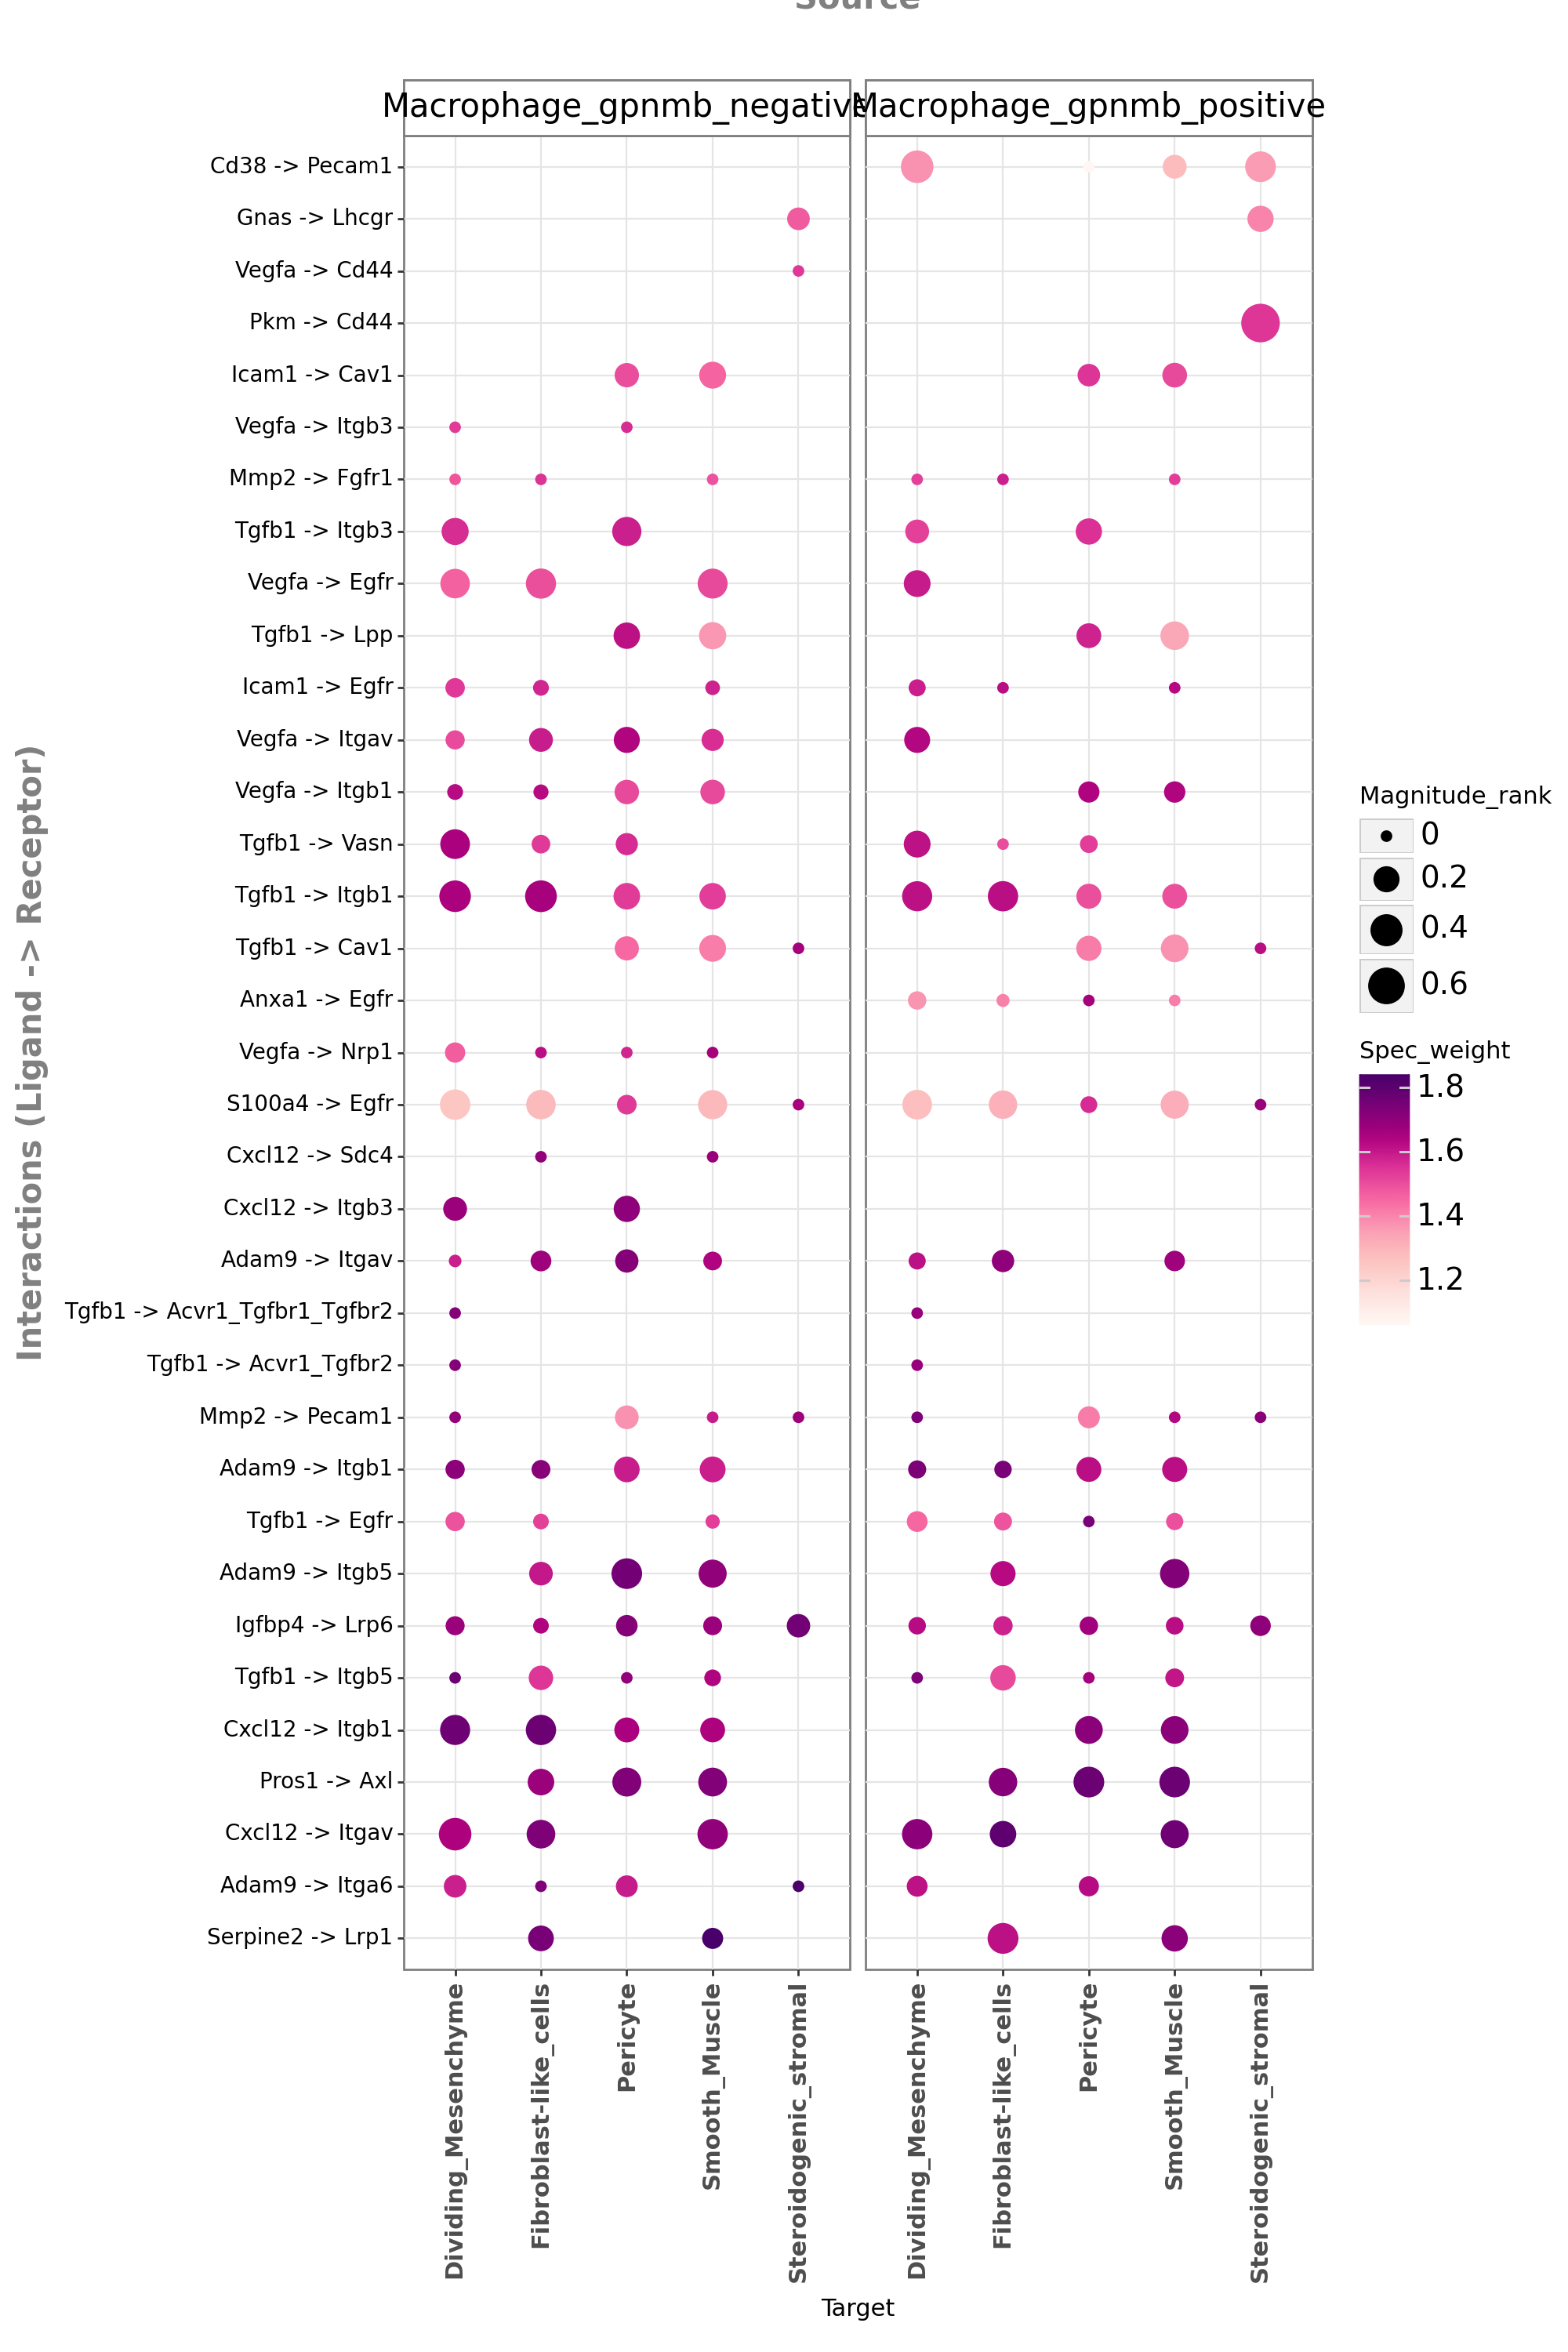

<Figure Size: (1000 x 1500)>

In [7]:
# 确认感兴趣的基因列表
genes_of_interest1 = ['Igfbp4', 'Icam1', 'Gnas','Tgfb1','Serpine2','S100a4','Pros1','Pkm','Mmp2','Cxcl12','Adam9',
                      'Anxa1','Vegfa','Mmp2','Cxcl12','Cd38']
genes_of_interest2 = ['Lrp6', 'Egfr', 'Cav1','Lhcgr','Acvr1_Tgfbr2','Acvr1_Tgfbr1_Tgfbr2','Lrp1','Axl','Cd44',
                      'Pecam1','Fgfr1','Pdgfrb','Sdc4','Itgb5','Itga6','Nrp1','Vasn','Itgb3','Itgb1','Lpp','Itgav','Pecam1']



# 创建基因掩码
genes_mask1 = liana_res_filtered['ligand_complex'].isin(genes_of_interest1)
genes_mask2 = liana_res_filtered['receptor_complex'].isin(genes_of_interest2)

# 同时应用两个条件
combined_mask = genes_mask1 & genes_mask2

# 根据组合掩码过滤结果
filtered_results = liana_res_filtered[combined_mask]
print(filtered_results.head())
# 更新 adata_cellphonedb.uns['liana_res'] 的内容
adata_cellphonedb.uns['liana_res1'] = filtered_results

# 调用 li.pl.dotplot 函数进行绘图
li.pl.dotplot(
    adata=adata_cellphonedb,
    colour='spec_weight',
    size='magnitude_rank',
    inverse_size=True,
    inverse_colour=True,
    source_labels=["Macrophage_gpnmb_positive", "Macrophage_gpnmb_negative"],
    target_labels=[
        "Steroidogenic_stromal",
        "Smooth_Muscle",
        "Pericyte",
        "Fibroblast-like_cells",
        "Dividing_Mesenchyme"
    ],
    filter_fun=lambda x: x['cellphone_pvals'] <= 0.05,
    top_n=500,
    orderby='spec_weight',
    orderby_ascending=True,
    figure_size=(10, 15),uns_key='liana_res1',cmap="RdPu"
)



In [9]:
my_plot = li.pl.dotplot(
    adata=adata_cellphonedb,
    colour='spec_weight',
    size='magnitude_rank',
    inverse_size=True,
    inverse_colour=True,
    source_labels=["Macrophage_gpnmb_positive", "Macrophage_gpnmb_negative"],
    target_labels=[
        "Steroidogenic_stromal",
        "Smooth_Muscle",
        "Pericyte",
        "Fibroblast-like_cells",
        "Dividing_Mesenchyme"
    ],
    filter_fun=lambda x: x['cellphone_pvals'] <= 0.05,
    top_n=500,
    orderby='spec_weight',
    orderby_ascending=True,
    figure_size=(10, 15),uns_key='liana_res1',cmap="RdPu"
)
my_plot


my_plot.save('figures/liana_dotplot.pdf')



Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


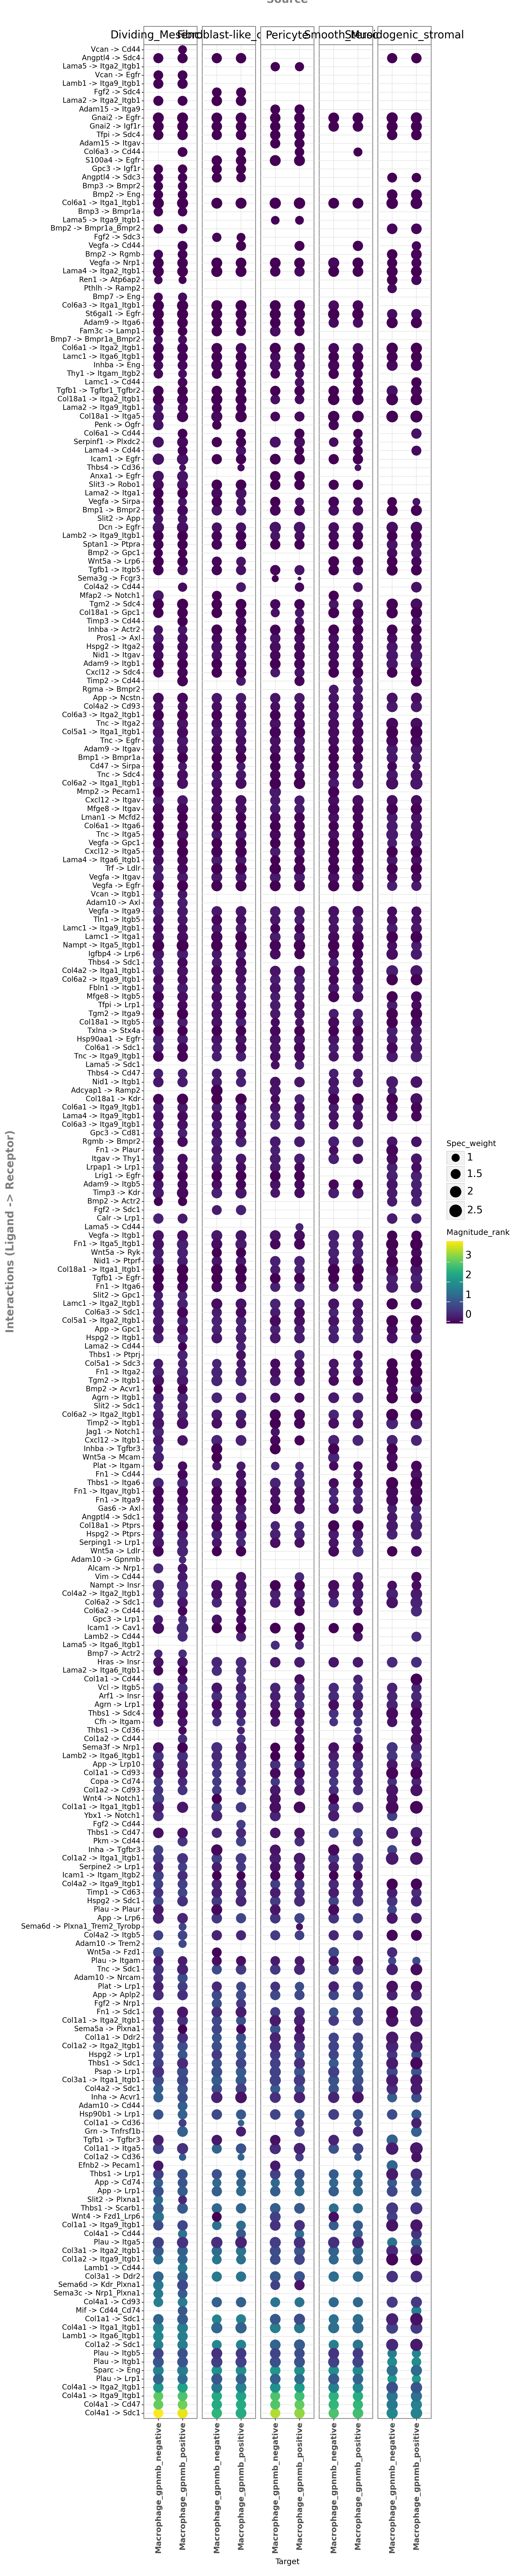

<Figure Size: (1000 x 5000)>

In [57]:
li.pl.dotplot(adata = adata_cellphonedb,
              colour='magnitude_rank',
              size='spec_weight',
              inverse_size=True,
              inverse_colour=True,
              target_labels=["Macrophage_gpnmb_positive","Macrophage_gpnmb_negative"],
              source_labels=[
                                          "Steroidogenic_stromal",
                                          "Smooth_Muscle",
                                          "Pericyte",
                                          "Fibroblast-like_cells",
                                          "Dividing_Mesenchyme"
                                          ],
              filter_fun=lambda x: x['cellphone_pvals'] <= 0.000,
              top_n=500,
              orderby='magnitude_rank',
              orderby_ascending=True,
              figure_size=(10, 50)
             )

In [3]:
import scanpy as sc
import numpy as np
import scipy

# 读取 AnnData 对象
adata_cellphonedb = sc.read_h5ad('Integrate/cellphonedb.h5ad')
adata_cellphonedb.raw = adata_cellphonedb.copy()
adata_cellphonedb

AnnData object with n_obs × n_vars = 128057 × 16421
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'Sample', '_indices', '_scvi_batch', '_scvi_labels', 'total_abundance', 'EN_Blood', 'EN_Lymph', 'Epithelium', 'GC_Antral', 'GC_Atretic', 'GC_CL_Active', 'GC_CL_Lytic', 'GC_Estrous', 'GC_Mitotic', 'GC_Mural', 'GC_Preantral', 'I_B_Cell', 'I_Dendritic_Cell', 'I_Granulocyte', 'I_Macrophage', 'I_T_Cell', 'M_Cortical Stroma', 'M_Dividing Mesenchyme', 'M_Immature Theca', 'M_Medullary Stroma', 'M_Pericyte', 'M_Smooth Muscle', 'M_Steroidogenic Theca', 'Oocyte', 'Level1_max_pred', 'Level1_max_pred_celltype', 'annotation', 'Gpnmb_expression', 'S_score', 'G2M_score', 'phase', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts-AAV', 'mean_counts-AAV', 'log1p_mean_counts

In [4]:
adata_cellphonedb.obs.annotation.value_counts()

annotation
Steroidogenic_stromal        55723
Smooth_Muscle                22794
Fibroblast-like_cells        15894
Macrophage_gpnmb_negative    15584
Pericyte                      8723
Dividing_Mesenchyme           7332
Macrophage_gpnmb_positive     2007
Name: count, dtype: int64

In [5]:
# 筛选出感兴趣的细胞类型
subset = adata_cellphonedb[adata_cellphonedb.obs['annotation'].isin(['Macrophage_gpnmb_positive', 'Fibroblast-like_cells'])].copy()

# 修改 'Fibroblast-like_cells' 为 'AAV_fibro' 和 'CTR_fibro'，根据 'Sample' 列的分组信息
subset.obs['annotation'] = subset.obs.apply(
    lambda x: 'AAV_fibro' if x['annotation'] == 'Fibroblast-like_cells' and x['Sample'] == 'AAV' else
              'CTR_fibro' if x['annotation'] == 'Fibroblast-like_cells' and x['Sample'] == 'CTR' else
              x['annotation'],
    axis=1
)

# 结果检查
subset.obs['annotation'].value_counts()

annotation
CTR_fibro                    8196
AAV_fibro                    7698
Macrophage_gpnmb_positive    2007
Name: count, dtype: int64

In [7]:
import liana as li
# Run rank_aggregate
li.mt.rank_aggregate(subset,
                     groupby='annotation',
                     resource_name='mouseconsensus',
                     expr_prop=0.1,
                     verbose=True)

Using resource `mouseconsensus`.
Using `.raw`!
94 features of mat are empty, they will be removed.
Converting `annotation` to categorical!
0.07 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 17901 samples and 1469 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:12<00:00, 83.06it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


In [9]:
subset.uns['liana_res'].head()

source                     target ligand_complex  \
1351  Macrophage_gpnmb_positive                  AAV_fibro           Apoe   
1348  Macrophage_gpnmb_positive                  AAV_fibro           Apoe   
1758  Macrophage_gpnmb_positive  Macrophage_gpnmb_positive           Apoe   
1756  Macrophage_gpnmb_positive  Macrophage_gpnmb_positive           Apoe   
1754  Macrophage_gpnmb_positive  Macrophage_gpnmb_positive           Apoe   

     receptor_complex  lr_means  cellphone_pvals  expr_prod  scaled_weight  \
1351           Scarb1  8.405066              0.0  25.018719       1.114721   
1348             Lrp1  8.319528              0.0  22.425194       1.089112   
1758           Scarb1  8.294185              0.0  21.656815       1.041402   
1756             Lrp1  8.206203              0.0  18.989244       0.999074   
1754            Abca1  8.127171              0.0  16.593021       1.123332   

      lr_logfc  spec_weight   lrscore  specificity_rank  magnitude_rank  
1351       inf     0.380830  0.988680               NaN        0.000002  
1348       inf     0.358308  0.988051               NaN        0.000009  
1758       inf     0.329656  0.987844               NaN        0.000021  
1756       inf     0.303409  0.987029               NaN        0.000037  
1754       inf     0.384152  0.986136               NaN        0.000058

In [10]:
df = subset.uns['liana_res']
# 查找基因为 'Gpnmb' 或 'Enpp2' 的行
result = df[df['ligand_complex'].isin(['Gpnmb'])]

# 显示结果
print(result)

Empty DataFrame
Columns: [source, target, ligand_complex, receptor_complex, lr_means, cellphone_pvals, expr_prod, scaled_weight, lr_logfc, spec_weight, lrscore, specificity_rank, magnitude_rank]
Index: []


In [11]:
# subset.write_h5ad("Integrate/liana_adata_subset_gpnmb_fibro_liana.h5ad")

... storing 'annotation' as categorical


In [12]:
adata_cellphonedb = sc.read_h5ad("Integrate/liana_adata_subset_gpnmb_fibro_liana.h5ad")

In [13]:
# 过滤 liana_res 以仅保留感兴趣的基因
import liana as li
liana_res_filtered = adata_cellphonedb.uns['liana_res']
liana_res_filtered = liana_res_filtered[liana_res_filtered["cellphone_pvals"] <= 0.05]
liana_res_filtered

source                     target ligand_complex  \
1351  Macrophage_gpnmb_positive                  AAV_fibro           Apoe   
1348  Macrophage_gpnmb_positive                  AAV_fibro           Apoe   
1758  Macrophage_gpnmb_positive  Macrophage_gpnmb_positive           Apoe   
1756  Macrophage_gpnmb_positive  Macrophage_gpnmb_positive           Apoe   
1754  Macrophage_gpnmb_positive  Macrophage_gpnmb_positive           Apoe   
...                         ...                        ...            ...   
149                   AAV_fibro                  AAV_fibro            Fn1   
24                    AAV_fibro                  AAV_fibro        Angptl4   
62                    AAV_fibro                  AAV_fibro        Col16a1   
60                    AAV_fibro                  AAV_fibro        Col15a1   
58                    AAV_fibro                  AAV_fibro        Col12a1   

     receptor_complex  lr_means  cellphone_pvals  expr_prod  scaled_weight  \
1351           Scarb1  8.405066              0.0  25.018719       1.114721   
1348             Lrp1  8.319528              0.0  22.425194       1.089112   
1758           Scarb1  8.294185              0.0  21.656815       1.041402   
1756             Lrp1  8.206203              0.0  18.989244       0.999074   
1754            Abca1  8.127171              0.0  16.593021       1.123332   
...               ...       ...              ...        ...            ...   
149              Sdc2  0.274106              0.0   0.046581       0.068696   
24               Sdc4  0.199800              0.0   0.032755       0.050720   
62        Itga1_Itgb1  0.183798              0.0   0.026918       0.077987   
60        Itga1_Itgb1  0.184029              0.0   0.027041       0.022139   
58        Itga1_Itgb1  0.187227              0.0   0.028747       0.062844   

      lr_logfc  spec_weight   lrscore  specificity_rank  magnitude_rank  
1351       inf     0.380830  0.988680               NaN        0.000002  
1348       inf     0.358308  0.988051               NaN        0.000009  
1758       inf     0.329656  0.987844               NaN        0.000021  
1756       inf     0.303409  0.987029               NaN        0.000037  
1754       inf     0.384152  0.986136               NaN        0.000058  
...        ...          ...       ...               ...             ...  
149  -1.268796     0.203473  0.790303               NaN        1.000000  
24   -0.258100     0.159700  0.759634               NaN        1.000000  
62   -1.332735     0.231808  0.741263               NaN        1.000000  
60   -1.563224     0.149540  0.741702               NaN        1.000000  
58   -1.265346     0.216976  0.747517               NaN        1.000000  

[872 rows x 13 columns]

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


                         source                     target ligand_complex  \
990                   CTR_fibro                  AAV_fibro       Serpine2   
1366  Macrophage_gpnmb_positive                  AAV_fibro           Cd38   
1298                  CTR_fibro  Macrophage_gpnmb_positive       Serpine2   
268                   AAV_fibro                  AAV_fibro          Tgfb1   
1513  Macrophage_gpnmb_positive                  AAV_fibro       Serpine2   

     receptor_complex  lr_means  cellphone_pvals  expr_prod  scaled_weight  \
990              Lrp1  0.926758              0.0   0.553629       0.223137   
1366           Pecam1  0.107180              0.0   0.011486       0.170561   
1298             Lrp1  0.813434              0.0   0.468803       0.133099   
268             Itgb3  0.130230              0.0   0.013827       0.029201   
1513             Lrp1  0.846907              0.0   0.317388       0.111643   

      lr_logfc  spec_weight   lrscore  specificity_rank  magnitude_r

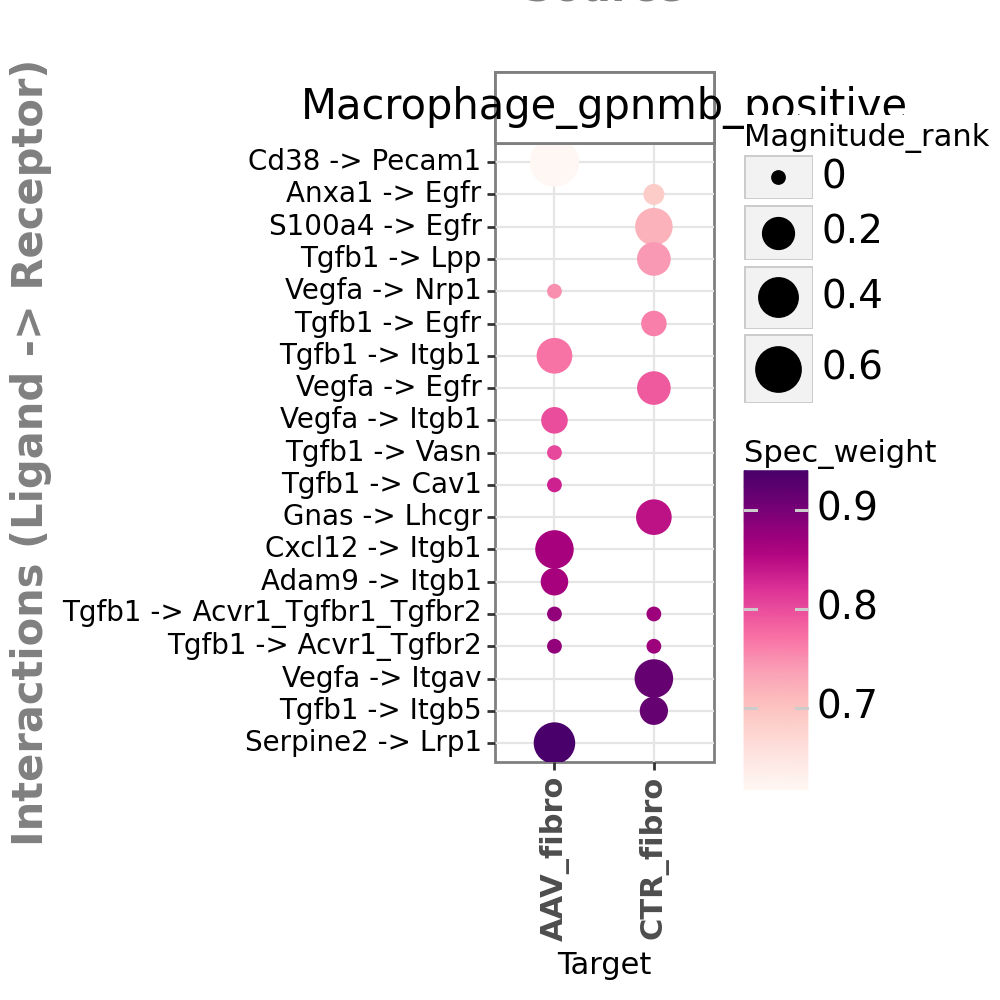

<Figure Size: (500 x 500)>

In [17]:
# 确认感兴趣的基因列表
genes_of_interest1 = ['Igfbp4', 'Icam1', 'Gnas','Tgfb1','Serpine2','S100a4','Pros1','Pkm','Mmp2','Cxcl12','Adam9',
                      'Anxa1','Vegfa','Mmp2','Cxcl12','Cd38']
genes_of_interest2 = ['Lrp6', 'Egfr', 'Cav1','Lhcgr','Acvr1_Tgfbr2','Acvr1_Tgfbr1_Tgfbr2','Lrp1','Axl','Cd44',
                      'Pecam1','Fgfr1','Pdgfrb','Sdc4','Itgb5','Itga6','Nrp1','Vasn','Itgb3','Itgb1','Lpp','Itgav','Pecam1']



# 创建基因掩码
genes_mask1 = liana_res_filtered['ligand_complex'].isin(genes_of_interest1)
genes_mask2 = liana_res_filtered['receptor_complex'].isin(genes_of_interest2)

# 同时应用两个条件
combined_mask = genes_mask1 & genes_mask2

# 根据组合掩码过滤结果
filtered_results = liana_res_filtered[combined_mask]
print(filtered_results.head())
# 更新 adata_cellphonedb.uns['liana_res'] 的内容
adata_cellphonedb.uns['liana_res1'] = filtered_results

# 调用 li.pl.dotplot 函数进行绘图
li.pl.dotplot(
    adata=adata_cellphonedb,
    colour='spec_weight',
    size='magnitude_rank',
    inverse_size=True,
    inverse_colour=True,
    source_labels=["Macrophage_gpnmb_positive"],
    target_labels=[
        "AAV_fibro",
        "CTR_fibro"
    ],
    filter_fun=lambda x: x['cellphone_pvals'] <= 0.05,
    top_n=500,
    orderby='spec_weight',
    orderby_ascending=True,
    figure_size=(5, 5),uns_key='liana_res1',cmap="RdPu"
)



In [18]:
my_plot = li.pl.dotplot(
    adata=adata_cellphonedb,
    colour='spec_weight',
    size='magnitude_rank',
    inverse_size=True,
    inverse_colour=True,
    source_labels=["Macrophage_gpnmb_positive"],
    target_labels=[
        "AAV_fibro",
        "CTR_fibro"
    ],
    filter_fun=lambda x: x['cellphone_pvals'] <= 0.05,
    top_n=500,
    orderby='spec_weight',
    orderby_ascending=True,
    figure_size=(5, 5),uns_key='liana_res1',cmap="RdPu"
)
my_plot


my_plot.save('figures/liana_dotplot_subset.pdf')

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
